### Code for Optimizing FATES Allometric Functions

#### Author: Katie Murenbeeld
#### Date: 19 July 2021
#### Updated: 24 Feb 2022

Within this notebook you will

1. Load appropriate libraries
2. Define allometric functions for the allometry equations that FATES currently uses
3. Load appropriate plant trait datasets
4. 

### 1. Load Libraries


In [1]:
# Load appropriate libraries
import xarray as xr # For looking at netcdf files .nc
import random
import numpy as np
import pandas as pd
import scipy as sp
import math as m
from scipy import optimize
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

### 2. Define allometric functions that FATES currently uses

In [2]:
def d2h_chave2014(d,p1,p2,p3):
    h = np.exp( p1 + p2*np.log(d) + p3*np.log(d)**2.0)
    return(h)

def d2h_poorter2006(d,p1,p2,p3):
    h = p1*(1.0 - np.exp(p2*d**p3))
    return(h)

def d2h_2pwr(d,p1,p2):
    h = p1*d**p2
    return(h)

def d2h_obrien(d,p1,p2):
    h = 10.0**(np.log10(d)*p1+p2)
    return(h)

def d2h_martcano(d,p1,p2,p3):
    h = (p1*d**p2)/(p3+d**p2)
    return(h)

def carea_2pwr(d, p1, p2):
    c = p1 * d ** p2
    return(c)

def d2blmax_salda(d,p1,p2,p3,rho):
    blmax = p1 * d**p2 * rho**p3
    return(blmax)

def d2blmax_2pwr(d,p1,p2):
    c2b = 2.0
    blmax    = (p1*d**p2) / c2b
    return(blmax)

def d2bagw_choj(dbh,p1,p2):
    ln_agb = p1+(p2*np.log(dbh))
    agb_choj = np.exp(ln_agb)
    return agb_choj

def d2bagw_sal(dbh,p1,p2,p3,p4):
    agb_sal = allom_frac * p1 * (h_sal_mod**p2) * (dbh**p3) * (rho**p4)
    return agb_sal

def d2bagw_pow(dbh,p1,p2):
    agb_pow = (p1*np.power(dbh,p2))/c2b
    return agb_pow

### 3) Load data

Here we are using data from:

1. Falster et al., 2011 A Biomass and Allometry Database (BAAD)
2. USDA Forest Inventory Analysis (FIA) for Idaho
3. USDA Height and diameter at breast height (dbh) data from the Boise Basin Experimental Forest (BBEF)

We subset the data for Idaho or the western US. We are looking at common conifer species of Idaho. These include:

* Ponderosa pine (*Pinus ponderosa*)
* Lodgepole pine (*Pinus contorta*)
* Western white pine (*Pinus monticola*)
* Douglas-fir (*Pseudotsuga menziesii*)
* Western hemlock (*Tsuga heterophylla*)
* Western red cedar (*Thuja plicata*)
* Western larch (*Larix occidentalis*)
* Grand fir (*Abies grandis*)
* Subalpine fir (*Abies lasiocarpa*)
* Engelmann spruce (*Picea engelmanni*)

For now, I am looking at the pines, which will comprise for PFT1, and Douglas-fir and W. hemlock which will comprise PFT4.

In [3]:
# Set the directories
baad_dir = '/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/FATES/baad_downloads/baad_data/'
baad_dir_out = '/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/FATES/baad_downloads/baad_data_out/'
bbef_dir = '/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/BBEF/DATA/'
bbef_dir_out = '/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/BBEF/DATA/'
fia_dir = '/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/Benchmarking_Sensitivity/FIA/FIA_ID/'
fia_dir_out = '/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/Benchmarking_Sensitivity/FIA/FIA_ID_OUT/'

In [4]:
# Read in the BAAD data
baad_df = pd.read_csv(baad_dir + 'baad_data_2.csv').reset_index() 
baad_df = baad_df[['species', 'location', 'h.t', 'd.bh', 'a.lf', 'a.cp', 'm.lf', 'ma.ilf', 'n.lf', 'm.so']].copy()

# Read in the BBEF data
bbef_df = pd.read_csv(bbef_dir + 'BBEF-all-trees-height_DBH_calcs.csv')

# Read in the FIA Idaho census data
fia_df = pd.read_csv(fia_dir + 'ID_TREE.csv')
fia_df = fia_df[['PLT_CN', 'COUNTYCD', 'INVYR', 'CONDID', 'AZIMUTH', 'SPCD', 'SPGRPCD', 
                       'DIA', 'HT', 'CR', 'CDENCD', 'BHAGE', 'FGROWCFGS', 'TPA_UNADJ',  
                       'DRYBIO_BG', 'CARBON_AG', 'CARBON_BG', 'DRYBIO_AG']].copy()

/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (102) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# For the FIA data rename the species of interest

conditions = [
        (fia_df['SPCD'] == 202), # Douglas fir
        (fia_df['SPCD'] == 242), # Western red cedar
        (fia_df['SPCD'] == 19),  # Subalpine fir
        (fia_df['SPCD'] == 119), # Western white pine
        (fia_df['SPCD'] == 17),  # Grand fir
        (fia_df['SPCD'] == 73),  # Western larch
        (fia_df['SPCD'] == 122), # Ponderosa pine
        (fia_df['SPCD'] == 263), # Western hemlock
        (fia_df['SPCD'] == 108), # Lodgepole pine
        (fia_df['SPCD'] == 93),  # Engleman spruce
    ]
choices = ['doug-fir', 'w_redcedar', 'subap_fir', 'ww_pine', 'grand_fir', 'w_larch', 'pondo_pine', 'w_hem', 'lodge_pine', 'engle_spruce']
    
fia_df['SPECIES'] = np.select(conditions, choices, default='none')

fia_df.head(2)



,PLT_CN,COUNTYCD,INVYR,CONDID,AZIMUTH,SPCD,SPGRPCD,DIA,HT,CR,CDENCD,BHAGE,FGROWCFGS,TPA_UNADJ,DRYBIO_BG,CARBON_AG,CARBON_BG,DRYBIO_AG,SPECIES
0,3156095010690,9,1991,1,89.0,202,10,10.6,57.0,65.0,NaN,28.0,0.643645,13.054000,110.124965,240.460065,55.062483,NaN,doug-fir
1,3156095010690,9,1991,1,133.0,202,10,6.8,45.0,45.0,NaN,32.0,0.260028,31.720993,37.630405,80.531243,18.815203,NaN,doug-fir


In [6]:
#baad_df['species'].unique()

In [7]:
# For each dataset sort out for the 10 conifer species of interest for the SCGSR work. Scratch that. 
# Just the species for PFT1 ( 3 pine species) and PFT 4 (W. Hemlock and Douglas Fir).

baad_10spc = baad_df.loc[(baad_df['species'] == 'Pinus ponderosa') | (baad_df['species'] == 'Pinus contorta') | (baad_df['species'] == 'Pinus monticola') | (baad_df['species'] == 'Pseudotsuga menzeisii') | (baad_df['species'] == 'Tsuga heterophylla') | (baad_df['species'] == 'Larix occidentalis') | (baad_df['species'] == 'Abies lasiocarpa') | (baad_df['species'] == 'Abies grandis') | (baad_df['species'] == 'Picea engelmanni') | (baad_df['species'] == 'Thuja plicata')].copy()

#bbef_10spc = bbef_df.loc[(bbef_df['Species'] == 'Ponderosa pine') | (bbef_df['Species'] == 'Lodgepole pine') | (bbef_df['Species'] == 'Douglas fir') | (bbef_df['Species'] == 'Douglas fir') | (bbef_df['Species'] == 'Douglas fir')].copy()
bbef_10spc = bbef_df.loc[(bbef_df['Species'] != 'Aspen') ].copy()
                         
fia_10spc = fia_df.loc[(fia_df['SPECIES'] == 'pondo_pine') | (fia_df['SPECIES'] == 'lodge_pine') | (fia_df['SPECIES'] == 'ww_pine') | (fia_df['SPECIES'] == 'doug-fir') | (fia_df['SPECIES'] == 'w_hem') | (fia_df['SPECIES'] == 'w_redcedar') | (fia_df['SPECIES'] == 'grand_fir') | (fia_df['SPECIES'] == 'subap_fir') | (fia_df['SPECIES'] == 'w_larch') | (fia_df['SPECIES'] == 'engle_spruce')].copy()



In [8]:
bbef_10spc

,BBEF Study-name,Year,Plot ID,Tree ID,Species,DBH (inches),Height (feet),DBH (cm),H (m),AGB,Unnamed: 10,Unnamed: 11,param 1,param 2
0,Amber Fuels,2013,451,1,Ponderosa pine,31.600000,127.0,80.264000,38.7096,7.961826,NaN,pines,-2.6177,2.4638
1,Amber Fuels,2013,451,2,Ponderosa pine,20.700001,102.0,52.578003,31.0896,5.063293,NaN,Doug fir,-2.4623,2.4852
2,Amber Fuels,2013,452,1,Ponderosa pine,19.000000,79.0,48.260000,24.0792,4.619666,NaN,firs,-3.1774,2.6426
3,Amber Fuels,2013,452,2,Ponderosa pine,16.900000,76.0,42.926000,23.1648,4.075513,NaN,NaN,NaN,NaN
4,Amber Fuels,2013,452,3,Ponderosa pine,44.900002,115.0,114.046005,35.0520,11.594535,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5518,Watershed,2005,99,993,Douglas fir,6.600000,51.0,16.764000,15.5448,1.786973,NaN,NaN,NaN,NaN
5519,Watershed,2005,99,994,Douglas fir,6.900000,52.0,17.526000,15.8496,1.874797,NaN,NaN,NaN,NaN
5520,Watershed,2005,99,9990,Ponderosa pine,23.900000,96.0,60.705999,29.2608,5.905157,NaN,NaN,NaN,NaN
5521,Watershed,2005,99,9991,Ponderosa pine,32.500000,113.0,82.550000,34.4424,8.204703,NaN,NaN,NaN,NaN


In [9]:
# Clean up and convert USDA FS data to metric 
baad_10spc['DBH (cm)'] = baad_10spc['d.bh']*100

bbef_10spc['DBH (m)'] = bbef_10spc['DBH (cm)']/100
bbef_10spc = bbef_10spc.drop(columns = ['Unnamed: 10', 'Unnamed: 11', 'param 1', 'param 2'])

fia_10spc['HT (m)'] = fia_10spc['HT'] * 0.3048
fia_10spc['DBH (cm)'] = fia_10spc['DIA'] * 2.54
fia_10spc['DBH (m)'] = fia_10spc['DIA'] * 0.0254

In [10]:
baad_10spc.head(2)
#bbef_2pfts

,species,location,h.t,d.bh,a.lf,a.cp,m.lf,ma.ilf,n.lf,m.so,DBH (cm)
3426,Thuja plicata,northern Rocky Mountains U.S.A.,0.54864,NaN,NaN,0.143013,0.029983,NaN,NaN,NaN,NaN
3428,Pinus ponderosa,northern Rocky Mountains U.S.A.,0.70104,NaN,NaN,0.186793,0.084007,NaN,NaN,NaN,NaN


In [11]:
# Review the max and min height by location (BAAD only)
print("max = ", baad_10spc.groupby('location')['h.t'].max(), "\nmin = ", baad_10spc.groupby('location')['h.t'].min())


max =  location
24 km east of Prince George, British Columbia, CA                                             6.936000
Gavin Lake                                                                                    5.820000
Priest River Experimental Forest                                                             44.989998
Pringle Butte and Lookout Mountain                                                           14.520000
central Oregon, USA                                                                          20.150000
eastern side of the Oregon Cascade Range, USA on a private forestland (Crown Pacific Co.)    35.750000
northern Rocky Mountains U.S.A.                                                              44.013120
western Montana, USA                                                                         22.070000
Name: h.t, dtype: float64 
min =  location
24 km east of Prince George, British Columbia, CA                                            0.68200
Gavin Lake      

In [12]:
# Review the mean height by location (BAAD only)
print("mean\n", baad_10spc.groupby('location')['h.t'].mean())


mean
 location
24 km east of Prince George, British Columbia, CA                                             2.670767
Gavin Lake                                                                                    1.861486
Priest River Experimental Forest                                                             27.480488
Pringle Butte and Lookout Mountain                                                            8.738611
central Oregon, USA                                                                           7.442581
eastern side of the Oregon Cascade Range, USA on a private forestland (Crown Pacific Co.)    18.044303
northern Rocky Mountains U.S.A.                                                               7.999469
western Montana, USA                                                                          8.865385
Name: h.t, dtype: float64


In [13]:
# Review basic stats on height
print("BAAD\n", baad_10spc['h.t'].describe(), "\nBBEF", bbef_10spc['H (m)'].describe(), "\nFIA", fia_10spc['HT'].describe())

# There is no way there is a 269 m tall tree at BBEF


BAAD
 count    1037.000000
mean        5.863459
std         8.079590
min         0.290000
25%         1.290000
50%         2.700000
75%         6.280000
max        44.989998
Name: h.t, dtype: float64 
BBEF count    5506.000000
mean       16.467371
std         9.844548
min         0.304800
25%         8.991600
50%        15.910560
75%        22.981920
max       269.443200
Name: H (m), dtype: float64 
FIA count    223647.000000
mean         54.872281
std          26.682908
min           1.000000
25%          36.000000
50%          53.000000
75%          71.000000
max         215.000000
Name: HT, dtype: float64


In [14]:
# Drop the index with the max height (269.4432m) from the bbef_2pfts

indx = bbef_10spc[ (bbef_10spc['H (m)'] == bbef_10spc['H (m)'].max())].index
bbef_10spc.drop(indx, inplace=True)

bbef_10spc['H (m)'].describe()

count    5505.000000
mean       16.421417
std         9.235978
min         0.304800
25%         8.991600
50%        15.910560
75%        22.981920
max        48.158400
Name: H (m), dtype: float64

In [15]:
indx

Int64Index([998], dtype='int64')

In [16]:
# Review basic stats on dbh
print("BAAD\n", baad_10spc['d.bh'].describe(), "\nBBEF", bbef_10spc['DBH (m)'].describe(), "\nFIA", fia_10spc['DBH (m)'].describe())



BAAD
 count    470.000000
mean       0.168984
std        0.173715
min        0.002540
25%        0.045720
50%        0.114300
75%        0.222885
max        0.863600
Name: d.bh, dtype: float64 
BBEF count    5505.000000
mean        0.271001
std         0.203184
min         0.002540
25%         0.132080
50%         0.223520
75%         0.355600
max         2.870200
Name: DBH (m), dtype: float64 
FIA count    223647.000000
mean          0.253500
std           0.163285
min           0.025400
25%           0.149860
50%           0.213360
75%           0.317500
max           2.405380
Name: DBH (m), dtype: float64


In [17]:
# Combine all of the DBH and H datasets into one dataframe
TOT_DBH = pd.concat([baad_10spc['d.bh'], bbef_10spc['DBH (m)'], fia_10spc['DBH (m)']], axis=0, ignore_index=True)
TOT_H = pd.concat([baad_10spc['h.t'], bbef_10spc['H (m)'], fia_10spc['HT (m)']], axis=0, ignore_index=True)

TOT = pd.concat([pd.DataFrame(TOT_DBH, columns=['DBH(m)']), pd.DataFrame(TOT_H, columns=['H(m)'])], axis=1)
TOT['DBH(cm)'] = TOT['DBH(m)'] * 100
TOT

,DBH(m),H(m),DBH(cm)
0,NaN,0.54864,NaN
1,NaN,0.70104,NaN
2,NaN,0.76200,NaN
3,NaN,0.85344,NaN
4,NaN,0.85344,NaN
...,...,...,...
241758,0.14224,6.09600,14.224
241759,0.38354,14.32560,38.354
241760,NaN,NaN,NaN
241761,0.15748,9.75360,15.748


In [18]:
# Find the mean height for specified ranges of DBH. 
# Here for a dbh of 10cm I took the measurements from 5-15cm to represent 10cm dbh. 
# Repeat the process up to 90cm.
# These values will be used to calculate parameters from the allometric equations (this acutally may not be necessary)

# Set dbh_mod to the ranges of dbh needed for calculation. In this case I want an array from 10-90 in steps of 10.
dbh_mod = np.arange(10, 100, 10) 

baad_mean_h = []

for i in dbh_mod:
    mask =  (baad_10spc['d.bh']>= ((i/100) - 0.05)) & (baad_10spc['d.bh']<((i/100) + 0.05))
    tmp_ = baad_10spc.loc[mask].copy()
    stats = tmp_['h.t'].mean()
    baad_mean_h.append(stats)
    
bbef_mean_h = []

for i in dbh_mod:
    mask =  (bbef_10spc['DBH (m)']>= ((i/100) - 0.05)) & (bbef_10spc['DBH (m)']<((i/100) + 0.05))
    tmp_ = bbef_10spc.loc[mask].copy()
    stats = tmp_['H (m)'].mean()
    bbef_mean_h.append(stats)

fia_mean_h = []

for i in dbh_mod:
    mask =  (fia_10spc['DBH (m)']>= ((i/100) - 0.05)) & (fia_10spc['DBH (m)']<((i/100) + 0.05))
    tmp_ = fia_10spc.loc[mask].copy()
    stats = tmp_['HT (m)'].mean()
    fia_mean_h.append(stats)
    
tot_mean_h = []

for i in dbh_mod:
    mask =  (TOT['DBH(m)']>= ((i/100) - 0.05)) & (TOT['DBH(m)']<((i/100) + 0.05))
    tot_ = TOT.loc[mask].copy()
    stats = tot_['H(m)'].mean()
    tot_mean_h.append(stats)

### 3) Fit parameters for the allometric functions using curve_fit()


In [19]:
## Create a vector or dataframe with the height and dbh values for each of the three datasets and for the combined 
## (TOT) dataset

BBEF_DBH = bbef_10spc['DBH (cm)'].values
BAAD_DBH = baad_10spc['DBH (cm)'].values
FIA_DBH = fia_10spc['DBH (cm)'].values
TOT_DBH = TOT['DBH(cm)'].values

BBEF_H = bbef_10spc['H (m)'].values
BAAD_H = baad_10spc['h.t'].values
FIA_H = fia_10spc['HT (m)'].values
TOT_H = TOT['H(m)'].values

BAAD_Hobs = baad_mean_h
BBEF_Hobs = bbef_mean_h
FIA_Hobs = fia_mean_h
TOT_Hobs = tot_mean_h


In [20]:
# If you would like you can define an objective/cost function for the d2h function. In this case RMSE.
# Then I want to create an objective function. I will use RMSE

def d2h_error(dbh,Hobs,p1,p2):
    h = 10**((np.log10(dbh))*p1+p2)
    RMSE = np.sqrt(np.mean((h-Hobs)**2)) # best to use numpy
    return RMSE

In [21]:
RMSE = d2h_error(10,6.24,0.65,0.18)
print(RMSE)

0.520829753919819


### 3.1) For the d2h allometries fit the data to all of the functions. Then just the datasets to the O'Brien function.

We will also randomly sample and optimize the parameters to get a distribution of p1 and p2 for the O'Brien equation.

[0.6087815  0.39083651]
[ 3.59553973e+01 -2.59992399e-02  1.02302808e+00]
[2.45946519 0.60877875]
[-0.90079593  1.67818987 -0.15458195]
[44.47719501  1.17295961 63.08534194]


/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


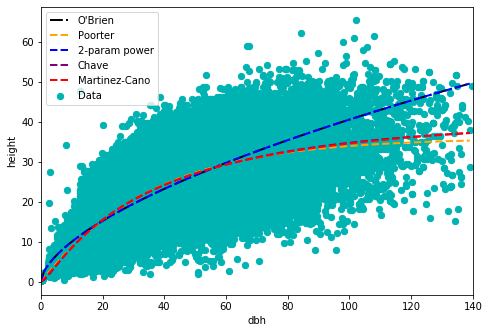

In [22]:
TOT_na = TOT.dropna(subset = ['DBH(cm)', 'H(m)']).copy()

pars_obrien, cov_obrien = curve_fit(f=d2h_obrien, xdata=TOT_na['DBH(cm)'].dropna(), ydata=TOT_na['H(m)'].dropna())
print(pars_obrien)
pars_poorter2006, cov_poorter2006 = curve_fit(f=d2h_poorter2006, xdata=TOT_na['DBH(cm)'].dropna(), ydata=TOT_na['H(m)'].dropna(), p0=[10,-0.01,1])
print(pars_poorter2006)
pars_2pwr, cov_2pwr = curve_fit(f=d2h_2pwr, xdata=TOT_na['DBH(cm)'].dropna(), ydata=TOT_na['H(m)'].dropna())
print(pars_2pwr)
pars_chave2014, cov_chave2014 = curve_fit(f=d2h_chave2014, xdata=TOT_na['DBH(cm)'].dropna(), ydata=TOT_na['H(m)'].dropna())
print(pars_chave2014)
pars_martcano, cov_martcano = curve_fit(f=d2h_martcano, xdata=TOT_na['DBH(cm)'].dropna(), ydata=TOT_na['H(m)'].dropna(), p0=[10,1,100])
print(pars_martcano)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh')
ax.set_ylabel('height')
ax.scatter(TOT['DBH(cm)'], TOT['H(m)'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), d2h_obrien(np.arange(140), *pars_obrien), linestyle='-.', linewidth=2, color='black', label="O'Brien")
ax.plot(np.arange(140), d2h_poorter2006(np.arange(140), *pars_poorter2006), linestyle='--', linewidth=2, color='orange', label="Poorter")
ax.plot(np.arange(140), d2h_2pwr(np.arange(140), *pars_2pwr), linestyle='--', linewidth=2, color='blue', label="2-param power")
ax.plot(np.arange(140), d2h_chave2014(np.arange(140), *pars_chave2014), linestyle='--', linewidth=2, color='purple', label="Chave")

ax.plot(np.arange(140), d2h_martcano(np.arange(140), *pars_martcano), linestyle='--', linewidth=2, color='red', label="Martinez-Cano")
ax.set_xlim(0,140)
ax.legend()

[0.82348719 0.05236976]
[0.63042623 0.34549468]
[0.6079209  0.39245748]


/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


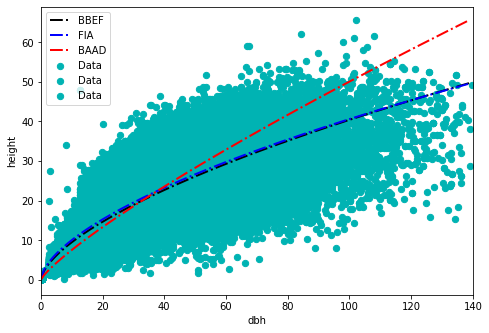

In [23]:
# Just using the O'Brien equation. Create optimal parameters for each of the three datasets.

baad_df2 = baad_10spc.dropna(subset=['DBH (cm)'])
parsbaad_obrien, covbaad_obrien = curve_fit(f=d2h_obrien, xdata=baad_df2['DBH (cm)'], ydata=baad_df2['h.t'])
print(parsbaad_obrien)
parsbbef_obrien, covbbef_obrien = curve_fit(f=d2h_obrien, xdata=BBEF_DBH, ydata=BBEF_H)
print(parsbbef_obrien)
parsfia_obrien, covfia_obrien = curve_fit(f=d2h_obrien, xdata=fia_10spc['DBH (cm)'].dropna(), ydata=fia_10spc['HT (m)'].dropna())
print(parsfia_obrien)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh')
ax.set_ylabel('height')
ax.scatter(fia_10spc['DBH (cm)'], fia_10spc['HT (m)'], s=40, color='#00b3b3', label='Data')
ax.scatter(BBEF_DBH, BBEF_H, s=40, color='#00b3b3', label='Data')
ax.scatter(baad_10spc['DBH (cm)'], baad_10spc['h.t'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), d2h_obrien(np.arange(140), *parsbbef_obrien), linestyle='-.', linewidth=2, color='black', label="BBEF")
ax.plot(np.arange(140), d2h_obrien(np.arange(140), *parsfia_obrien), linestyle='-.', linewidth=2, color='blue', label="FIA")
ax.plot(np.arange(140), d2h_obrien(np.arange(140), *parsbaad_obrien), linestyle='-.', linewidth=2, color='red', label="BAAD")
ax.set_xlim(0,140)
ax.legend()



In [24]:
# From the total dataset, sample 1000 random samples and calculate the optimal parameters for O'Brien.
# Repeat the sampling and optimization 100 times.
# Create histograms for the two parameters.

smp_opt_d2h = []

def d2h_params(data):
    smp_mean_h = []
    for i in dbh_mod:
        smp = data.sample(1000).dropna()
            
    smp_opt, smp_cov = curve_fit(f=d2h_obrien, xdata=smp['DBH(cm)'], ydata=smp['H(m)'])
    smp_opt_d2h.append(smp_opt)
    return smp_opt

In [25]:
smp_opt_d2h = []

for x in range(1,101):
    d2h_params(TOT)
    D2H_PARAMS_DF = smp_opt_d2h

d2h_params_df = pd.DataFrame(D2H_PARAMS_DF, columns=['d2h_p1', 'd2h_p2'])

(array([ 2.,  4., 20., 16., 12., 15., 10., 14.,  2.,  5.]),
 array([0.56687732, 0.57579019, 0.58470306, 0.59361592, 0.60252879,
        0.61144166, 0.62035453, 0.62926739, 0.63818026, 0.64709313,
        0.65600599]),
 <a list of 10 Patch objects>)

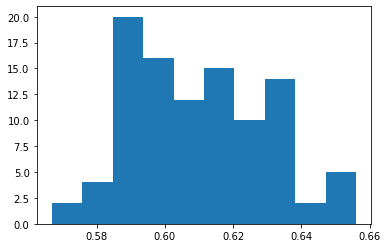

In [26]:
plt.hist(d2h_params_df['d2h_p1'])

(array([ 6.,  4., 11., 16., 13., 10., 20., 15.,  2.,  3.]),
 array([0.32907061, 0.3412696 , 0.35346859, 0.36566759, 0.37786658,
        0.39006557, 0.40226456, 0.41446355, 0.42666255, 0.43886154,
        0.45106053]),
 <a list of 10 Patch objects>)

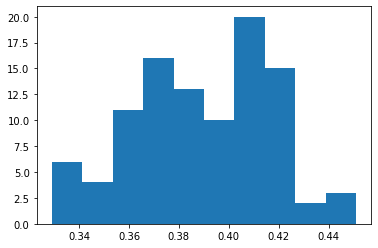

In [27]:
plt.hist(d2h_params_df['d2h_p2'])

In [28]:
# read out to a csv for use in the traits matrix
#d2h_params_df.to_csv('/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/FATES/SCGSR_PARAMS/d2h_params_10spc_20210727.csv', index=False)


### 3.2) We will optimize for the leaf biomass and crown area allometries using the BAAD data. 

#### First, projected crown area ($m^2$)

In [29]:
baad_10spc.dropna(subset=['a.cp', 'DBH (cm)'])

,species,location,h.t,d.bh,a.lf,a.cp,m.lf,ma.ilf,n.lf,m.so,DBH (cm)
3477,Pinus ponderosa,northern Rocky Mountains U.S.A.,1.402080,0.00762,NaN,0.263407,0.066997,NaN,NaN,NaN,0.762
3480,Thuja plicata,northern Rocky Mountains U.S.A.,1.432560,0.00762,NaN,1.349139,0.156991,NaN,NaN,NaN,0.762
3483,Larix occidentalis,northern Rocky Mountains U.S.A.,1.524000,0.01270,NaN,0.843486,0.189015,NaN,NaN,NaN,1.270
3484,Thuja plicata,northern Rocky Mountains U.S.A.,1.584960,0.00254,NaN,1.681134,0.247983,NaN,NaN,NaN,0.254
3485,Pinus monticola,northern Rocky Mountains U.S.A.,1.584960,0.01016,NaN,0.531921,0.366010,NaN,NaN,NaN,1.016
...,...,...,...,...,...,...,...,...,...,...,...
11641,Pinus ponderosa,Priest River Experimental Forest,3.570000,0.04830,6.221753,0.833229,0.808352,NaN,NaN,NaN,4.830
11642,Pinus ponderosa,Priest River Experimental Forest,31.929997,0.70610,970.338487,36.513951,135.146738,NaN,NaN,NaN,70.610
11643,Pinus ponderosa,Priest River Experimental Forest,6.920000,0.11430,36.523412,4.856518,4.806629,NaN,NaN,NaN,11.430
11644,Pinus ponderosa,Priest River Experimental Forest,5.849999,0.11940,34.204490,3.397947,4.770014,NaN,NaN,NaN,11.940


[0.15133808 1.34504714]


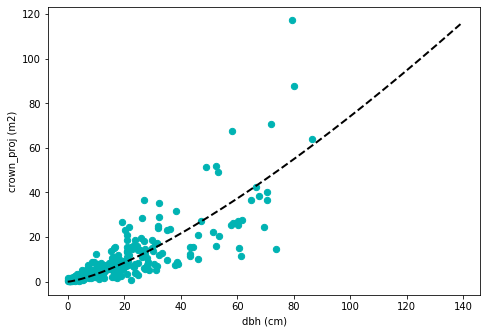

In [30]:
baad_acp = baad_10spc.dropna(subset=['a.cp', 'DBH (cm)'])
crownarea_pars, crownarea_cov = curve_fit(f=carea_2pwr, xdata=baad_acp['DBH (cm)'], ydata=baad_acp['a.cp'])
print(crownarea_pars)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('crown_proj (m2)')
ax.scatter(baad_acp['DBH (cm)'], baad_acp['a.cp'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), carea_2pwr(np.arange(140), *crownarea_pars), linestyle='--', linewidth=2, color='black')


(array([359.,  83.,  38.,  26.,  12.,  14.,  15.,   5.,   6.,   3.,   7.,
          5.,   2.,   1.,   0.,   4.,   1.,   1.,   1.,   0.,   0.,   2.,
          1.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([6.36172512e-03, 2.35283169e+00, 4.69930165e+00, 7.04577161e+00,
        9.39224158e+00, 1.17387115e+01, 1.40851815e+01, 1.64316515e+01,
        1.87781214e+01, 2.11245914e+01, 2.34710614e+01, 2.58175313e+01,
        2.81640013e+01, 3.05104712e+01, 3.28569412e+01, 3.52034112e+01,
        3.75498811e+01, 3.98963511e+01, 4.22428211e+01, 4.45892910e+01,
        4.69357610e+01, 4.92822309e+01, 5.16287009e+01, 5.39751709e+01,
        5.63216408e+01, 5.86681108e+01, 6.10145808e+01, 6.33610507e+01,
        6.57075207e+01, 6.80539906e+01, 7.04004606e+01, 7.27469306e+01,
        7.50934005e+01, 7.74398705e+01, 7.97863405e+01, 8.21328104e+01,
        8.

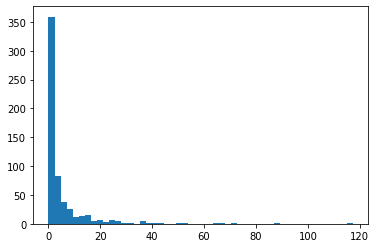

In [31]:
plt.hist(baad_10spc['a.cp'].dropna(), bins=50)
plt.show()

In [32]:
baad_10spc['a.cp'].describe()

count    591.000000
mean       5.153063
std       10.492777
min        0.006362
25%        0.456037
50%        1.681134
75%        4.882628
max      117.329860
Name: a.cp, dtype: float64

In [33]:
acp_log = np.log(baad_10spc['a.cp'])
acp_log.describe()

count    591.000000
mean       0.383445
std        1.721818
min       -5.057456
25%       -0.785182
50%        0.519468
75%        1.585669
max        4.764989
Name: a.cp, dtype: float64

#### Then, leaf area ($m^2$)

In [34]:
baad_10spc.dropna(subset=['a.lf', 'DBH (cm)'])

,species,location,h.t,d.bh,a.lf,a.cp,m.lf,ma.ilf,n.lf,m.so,DBH (cm)
5992,Pinus ponderosa,"eastern side of the Oregon Cascade Range, USA ...",32.60,0.627241,548.5200,NaN,75.39,0.139586,NaN,NaN,62.724080
5993,Pinus ponderosa,"eastern side of the Oregon Cascade Range, USA ...",33.60,0.544669,627.6800,NaN,85.41,0.137430,NaN,NaN,54.466945
5994,Pinus ponderosa,"eastern side of the Oregon Cascade Range, USA ...",34.10,0.661811,593.0900,NaN,94.95,0.159400,NaN,NaN,66.181146
5995,Pinus ponderosa,"eastern side of the Oregon Cascade Range, USA ...",31.70,0.677967,415.7100,NaN,62.74,0.154386,NaN,NaN,67.796716
5996,Pinus ponderosa,"eastern side of the Oregon Cascade Range, USA ...",33.50,0.608698,575.4500,NaN,83.92,0.143859,NaN,NaN,60.869755
...,...,...,...,...,...,...,...,...,...,...,...
12272,Pinus ponderosa,"central Oregon, USA",12.90,0.231140,122.5351,NaN,NaN,NaN,NaN,NaN,23.114000
12273,Pinus ponderosa,"central Oregon, USA",17.95,0.312420,132.5742,NaN,NaN,NaN,NaN,NaN,31.242000
12274,Pinus ponderosa,"central Oregon, USA",14.53,0.347980,134.6993,NaN,NaN,NaN,NaN,NaN,34.798000
12275,Pinus ponderosa,"central Oregon, USA",20.10,0.342900,287.5394,NaN,NaN,NaN,NaN,NaN,34.290000


[0.49870982 1.7026955 ]


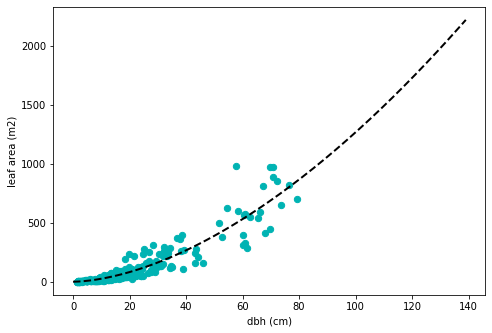

In [35]:
baad_alf = baad_10spc.dropna(subset=['a.lf', 'DBH (cm)'])
leafarea_pars, leafarea_cov = curve_fit(f=carea_2pwr, xdata=baad_alf['DBH (cm)'], ydata=baad_alf['a.lf'])
print(leafarea_pars)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf area (m2)')
ax.scatter(baad_alf['DBH (cm)'], baad_alf['a.lf'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), carea_2pwr(np.arange(140), *leafarea_pars), linestyle='--', linewidth=2, color='black')
#ax.set_xlim(0,100)

(array([269.,  42.,  13.,  12.,   9.,   4.,   4.,   1.,   4.,   4.,   1.,
          0.,   3.,   1.,   3.]),
 array([2.65147650e-02, 6.56656984e+01, 1.31304882e+02, 1.96944066e+02,
        2.62583249e+02, 3.28222433e+02, 3.93861616e+02, 4.59500800e+02,
        5.25139984e+02, 5.90779167e+02, 6.56418351e+02, 7.22057535e+02,
        7.87696718e+02, 8.53335902e+02, 9.18975085e+02, 9.84614269e+02]),
 <a list of 15 Patch objects>)

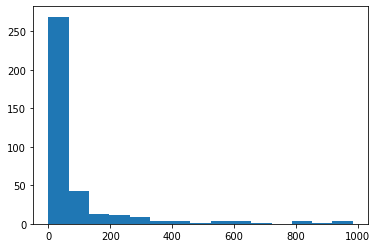

In [36]:
plt.hist(baad_10spc['a.lf'].dropna(), bins=15)

In [37]:
baad_10spc['a.lf'].describe()

count    370.000000
mean      81.873704
std      166.086398
min        0.026515
25%        1.693390
50%       14.892900
75%       76.405700
max      984.614269
Name: a.lf, dtype: float64

In [38]:
alf_log = np.log(baad_10spc['a.lf'])
alf_log.describe()

count    370.000000
mean       2.436646
std        2.402231
min       -3.630054
25%        0.526651
50%        2.700801
75%        4.335966
max        6.892250
Name: a.lf, dtype: float64

#### Calculate the leaf crown exponent difference

In [39]:
leaf_crown_exponent_diff = crownarea_pars[1] - leafarea_pars[1]
print(leaf_crown_exponent_diff)

-0.3576483665860988


#### Next, the leaf mass (kg)

In [40]:
baad_10spc.dropna(subset=['m.lf', 'DBH (cm)'])

,species,location,h.t,d.bh,a.lf,a.cp,m.lf,ma.ilf,n.lf,m.so,DBH (cm)
3477,Pinus ponderosa,northern Rocky Mountains U.S.A.,1.40208,0.00762,NaN,0.263407,0.066997,NaN,NaN,NaN,0.762
3480,Thuja plicata,northern Rocky Mountains U.S.A.,1.43256,0.00762,NaN,1.349139,0.156991,NaN,NaN,NaN,0.762
3483,Larix occidentalis,northern Rocky Mountains U.S.A.,1.52400,0.01270,NaN,0.843486,0.189015,NaN,NaN,NaN,1.270
3484,Thuja plicata,northern Rocky Mountains U.S.A.,1.58496,0.00254,NaN,1.681134,0.247983,NaN,NaN,NaN,0.254
3485,Pinus monticola,northern Rocky Mountains U.S.A.,1.58496,0.01016,NaN,0.531921,0.366010,NaN,NaN,NaN,1.016
...,...,...,...,...,...,...,...,...,...,...,...
19395,Abies lasiocarpa,"24 km east of Prince George, British Columbia, CA",2.43000,0.02510,NaN,NaN,0.536340,NaN,NaN,1.18675,2.510
19396,Abies lasiocarpa,"24 km east of Prince George, British Columbia, CA",5.29000,0.06560,NaN,NaN,0.985780,NaN,NaN,4.51192,6.560
19397,Abies lasiocarpa,"24 km east of Prince George, British Columbia, CA",6.93600,0.06540,NaN,NaN,0.845220,NaN,NaN,6.65497,6.540
19398,Abies lasiocarpa,"24 km east of Prince George, British Columbia, CA",5.45000,0.06290,NaN,NaN,0.781350,NaN,NaN,5.25157,6.290


[0.05766237 1.75023211]


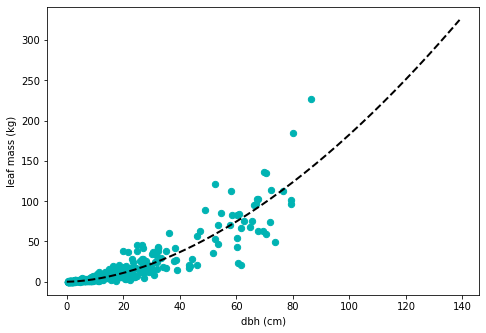

In [41]:
baad_mlf = baad_10spc.dropna(subset=['m.lf', 'DBH (cm)'])
leafmass_pars, leafmass_cov = curve_fit(f=carea_2pwr, xdata=baad_mlf['DBH (cm)'], ydata=baad_mlf['m.lf'])
print(leafmass_pars)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf mass (kg)')
ax.scatter(baad_mlf['DBH (cm)'], baad_mlf['m.lf'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), carea_2pwr(np.arange(140), *leafmass_pars), linestyle='--', linewidth=2, color='black')

[0.11532665 1.75022807]


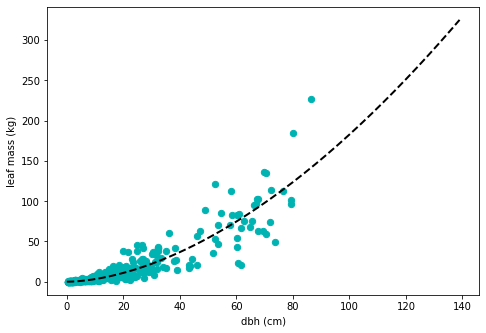

In [42]:
baad_mlf = baad_10spc.dropna(subset=['m.lf', 'DBH (cm)'])
leafmass_pars2, leafmass_cov2 = curve_fit(f=d2blmax_2pwr, xdata=baad_mlf['DBH (cm)'], ydata=baad_mlf['m.lf'])
print(leafmass_pars2)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf mass (kg)')
ax.scatter(baad_mlf['DBH (cm)'], baad_mlf['m.lf'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), d2blmax_2pwr(np.arange(140), *leafmass_pars2), linestyle='--', linewidth=2, color='black')

In [43]:
mlf_df = baad_mlf[['DBH (cm)','m.lf']].copy()
mlf_cov = mlf_df.cov()
mlf_cov

,DBH (cm),m.lf
DBH (cm),364.816949,486.203787
m.lf,486.203787,846.873595


(array([0.05370439, 0.00529107, 0.00198415, 0.00119049, 0.00132277,
        0.00066138, 0.00079366, 0.00052911, 0.00026455, 0.        ,
        0.        , 0.        , 0.00013228, 0.        , 0.00013228]),
 array([2.01000000e-03, 1.51521160e+01, 3.03022220e+01, 4.54523280e+01,
        6.06024340e+01, 7.57525400e+01, 9.09026460e+01, 1.06052752e+02,
        1.21202858e+02, 1.36352964e+02, 1.51503070e+02, 1.66653176e+02,
        1.81803282e+02, 1.96953388e+02, 2.12103494e+02, 2.27253600e+02]),
 <a list of 15 Patch objects>)

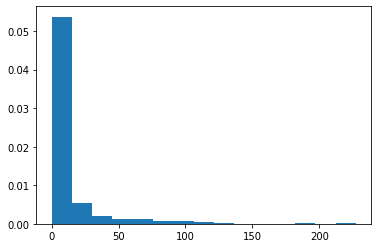

In [44]:
plt.hist(baad_10spc['m.lf'].dropna(), bins=15, density=True)

In [45]:
baad_10spc['m.lf'].describe()

count    499.000000
mean      11.515145
std       25.604243
min        0.002010
25%        0.177993
50%        1.229256
75%        9.450756
max      227.253600
Name: m.lf, dtype: float64

In [46]:
mlf_log = np.log(baad_10spc['m.lf'])
mlf_log.describe()

count    499.000000
mean       0.213758
std        2.512339
min       -6.209621
25%       -1.726029
50%        0.206409
75%        2.246080
max        5.426067
Name: m.lf, dtype: float64

### From the distributions of the leaf and crown data generate samples to then calculate parameter values from

In [47]:
acp = np.random.lognormal(mean=0.453849, sigma=2.017091, size=100)
#plt.hist(acp, bins=100)
#plt.show()

In [48]:
alf = np.random.lognormal(mean=3.060019, sigma=2.225335, size=100)
#plt.hist(alf, bins=100)
#plt.show()

In [49]:
mlf = np.random.lognormal(mean=1.054723, sigma=2.409439, size=100)
#plt.hist(mlf, bins=100)
#plt.show()

In [50]:
np.log(1)

0.0

### 3.3 Diameter to above ground biomass (d2bagw)
Here I will test the Chojnacky (2014), the Saldarriaga et al. (1998) and the FATES 2 parameter power functions.

In [51]:
# From Delucia (2000), in montane ponderosa pine at dbh=50, agb=945. We will use this as a guide.
# We need to create an objective/cost function. Use RMSE for now.

def RMSE_d2bagw(agb_mod):
    RMSE_d2bagw = np.sqrt(np.mean((agb_mod-agb_obs)**2)) 
    return RMSE_d2bagw

# For d2abagw we will calculate the 

In [52]:
# Test the functions at dbh=50 to find RMSE for observed agb at dbh 50.
dbh_bagw = 50
agb_obs=945
allom_frac=0.6
c2b=2

# Chojnacky with default parameters for pines with density < 0.45
agb_choj = d2bagw_choj(dbh_bagw,-2.6177,2.4638)

# Saldarriaga with default parameters
#agb_sal = d2bagw_sal(dbh_bagw,0.284,0.57,1.94,1)

# 2-parameter with default parameters
agb_pow = d2bagw_pow(dbh_bagw,0.1,2.4)

#print("agb_choj =", agb_choj, "agb_sal=",agb_sal,"agb_pow=",agb_pow)
print("agb_choj =", agb_choj, "agb_pow=",agb_pow)

agb_choj = 1119.6173798341167 agb_pow= 597.720312368773


In [53]:
# Calculate the RMSE for each of the functions

RMSE_choj = RMSE_d2bagw(agb_choj)

#RMSE_sal = RMSE_d2bagw(agb_sal)

RMSE_pow = RMSE_d2bagw(agb_pow)

#print("choj RMSE=",RMSE_choj,", sal RMSE=",RMSE_sal,", power RMSE=",RMSE_pow)
print("choj RMSE=",RMSE_choj,", power RMSE=",RMSE_pow)

choj RMSE= 174.61737983411672 , power RMSE= 347.27968763122703


Well, they are all terrible.  How can I make them fit better?

In [69]:
# From the FIA data, calculate per acre above ground caron by multiplying the CARBON_AG * TPA_UNADJ

# Drop rows with na for CARBON_AG == 0.000
fia_agb = fia_2pfts.dropna(subset = ['DRYBIO_BG']).copy()

fia_agb['AGB'] = (fia_agb['CARBON_AG'] * fia_agb['TPA_UNADJ'])

# Convert lbC/ac to gC/m^2 to match FATES

fia_agb['AGB'] = (fia_agb['AGB'].values * 453.592 * 0.000247105)
fia_agb['AGB'].mean()


218.40367110124382

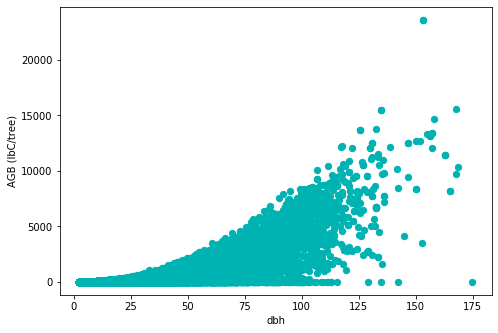

In [66]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh')
ax.set_ylabel('AGB (lbC/tree)')
ax.scatter(fia_2pfts['DBH (cm)'], fia_2pfts['CARBON_AG'], s=40, color='#00b3b3', label='Data')

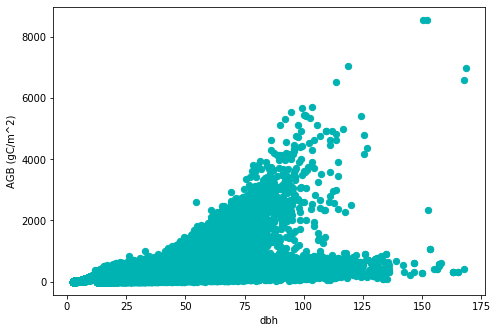

In [70]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh')
ax.set_ylabel('AGB (gC/m^2)')
#ax.scatter(fia_agb['DBH (cm)'], fia_agb['AGB'], s=40, color='#00b3b3', label='Data')
ax.scatter(fia_agb['DBH (cm)'], fia_agb['AGB'], s=40, color='#00b3b3', label='Data')


In [71]:
fia_pft1 = fia_agb.loc[(fia_2pfts['SPCD'] == 122) | (fia_agb['SPCD'] == 119) | (fia_agb['SPCD'] == 108)]
fia_pft4 = fia_agb.loc[(fia_2pfts['SPCD'] == 263) | (fia_agb['SPCD'] == 202)]

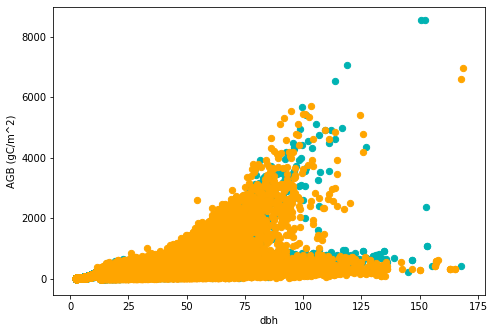

In [72]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh')
ax.set_ylabel('AGB (gC/m^2)')
ax.scatter(fia_pft1['DBH (cm)'], fia_pft1['AGB'], s=40, color='#00b3b3', label='Data')
ax.scatter(fia_pft4['DBH (cm)'], fia_pft4['AGB'], s=40, color='#ffa500', label='Data')

In [73]:
fia_agb = fia_agb.dropna(subset=['AGB', 'DBH (cm)'])
fia_agb

,PLT_CN,COUNTYCD,INVYR,CONDID,AZIMUTH,SPCD,SPGRPCD,DIA,HT,CR,...,TPA_UNADJ,DRYBIO_BG,CARBON_AG,CARBON_BG,DRYBIO_AG,SPECIES,HT (m),DBH (cm),DBH (m),AGB
0,3156095010690,9,1991,1,89.0,202,10,10.6,57.0,65.0,...,13.054000,110.124965,240.460065,55.062483,NaN,doug-fir,17.3736,26.924,0.26924,351.830502
1,3156095010690,9,1991,1,133.0,202,10,6.8,45.0,45.0,...,31.720993,37.630405,80.531243,18.815203,NaN,doug-fir,13.7160,17.272,0.17272,286.324226
3,3156095010690,9,1991,1,253.0,202,10,20.7,87.0,75.0,...,3.423000,568.025095,1261.636193,284.012548,NaN,doug-fir,26.5176,52.578,0.52578,484.047474
4,3156095010690,9,1991,1,285.0,202,10,17.3,78.0,75.0,...,4.901000,368.684807,816.035383,184.342404,NaN,doug-fir,23.7744,43.942,0.43942,448.270967
5,3156095010690,9,1991,1,47.0,202,10,1.4,12.0,25.0,...,60.000000,0.698412,1.129724,0.349206,NaN,doug-fir,3.6576,3.556,0.03556,7.597497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269937,354845607489998,81,2019,1,305.0,108,21,5.3,30.0,80.0,...,6.018046,11.534544,24.284499,5.767272,48.568998,lodge_pine,9.1440,13.462,0.13462,16.380667
269938,354845607489998,81,2019,1,356.0,108,21,5.6,20.0,75.0,...,6.018046,8.629705,18.241712,4.314853,36.483424,lodge_pine,6.0960,14.224,0.14224,12.304615
269939,354845607489998,81,2019,1,186.0,202,10,15.1,47.0,75.0,...,6.018046,163.560614,360.897561,81.780307,721.795121,doug-fir,14.3256,38.354,0.38354,243.436878
269942,354845607489998,81,2019,1,234.0,108,21,6.2,32.0,75.0,...,6.018046,19.063873,40.572438,9.531937,81.144876,lodge_pine,9.7536,15.748,0.15748,27.367399


[0.89355118 1.36203131]
[0.72792586 0.9359454  1.36203084 1.42626814]
[4.88700458 1.36206117]


/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log


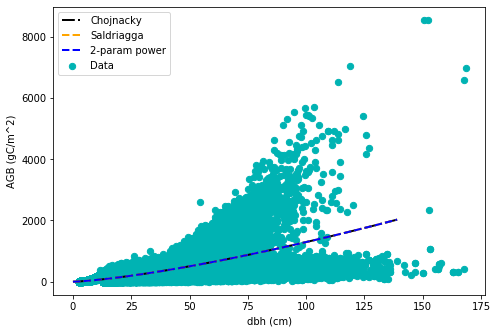

In [74]:
#fia_agb = fia_2pfts.dropna(subset=['AGB', 'DBH (cm)'])

# Define constants for the functions

# In d2bagw_sal
allom_frac = 0.6 
rho = 0.367 # Density of tree from USDA Survey of Tree Density, value for S. Idaho ponderosa pine
h_sal_mod = 29 # Observed height at dbh=50 from baad
# In d2bagw_pow
c2b = 2

pars_choj, cov_choj = curve_fit(f=d2bagw_choj, xdata=fia_agb['DBH (cm)'], ydata=fia_agb['AGB'])
print(pars_choj)
pars_sal, cov_sal = curve_fit(f=d2bagw_sal, xdata=fia_agb['DBH (cm)'], ydata=fia_agb['AGB'])
print(pars_sal)
pars_pow, cov_pow = curve_fit(f=d2bagw_pow, xdata=fia_agb['DBH (cm)'], ydata=fia_agb['AGB'])
print(pars_pow)

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('AGB (gC/m^2)')
ax.scatter(fia_agb['DBH (cm)'], fia_agb['AGB'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), d2bagw_choj(np.arange(140), *pars_choj), linestyle='-.', linewidth=2, color='black', label="Chojnacky")
ax.plot(np.arange(140), d2bagw_sal(np.arange(140), *pars_sal), linestyle='--', linewidth=2, color='orange', label="Saldriagga")
ax.plot(np.arange(140), d2bagw_pow(np.arange(140), *pars_pow), linestyle='--', linewidth=2, color='blue', label="2-param power")

ax.legend()



In [75]:
## Something happened to the AGB with the conversion from lbC/tree to gC/m^2. Scewing the parameters. 
## Maybe mask for dbh>75 & agb <1000?
## I think just don't worry about the d2agb parameters.

[-1.53024522  2.15347754]
[0.09186371 0.84767401 2.15347752 1.48279119]
[0.43296559 2.1534773 ]


/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log


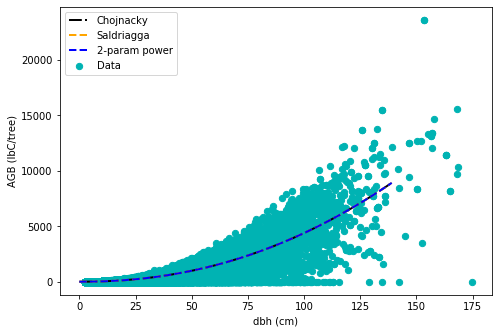

In [76]:
fia_cag = fia_2pfts.dropna(subset=['CARBON_AG', 'DBH (cm)'])

# Define constants for the functions

# In d2bagw_sal
allom_frac = 0.6 
rho = 0.367 # Density of tree from USDA Survey of Tree Density, value for S. Idaho ponderosa pine
h_sal_mod = 29 # Observed height at dbh=50 from baad
# In d2bagw_pow
c2b = 2

pars_choj, cov_choj = curve_fit(f=d2bagw_choj, xdata=fia_cag['DBH (cm)'], ydata=fia_cag['CARBON_AG'])
print(pars_choj)
pars_sal, cov_sal = curve_fit(f=d2bagw_sal, xdata=fia_cag['DBH (cm)'], ydata=fia_cag['CARBON_AG'])
print(pars_sal)
pars_pow, cov_pow = curve_fit(f=d2bagw_pow, xdata=fia_cag['DBH (cm)'], ydata=fia_cag['CARBON_AG'])
print(pars_pow)

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('AGB (lbC/tree)')
ax.scatter(fia_cag['DBH (cm)'], fia_cag['CARBON_AG'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), d2bagw_choj(np.arange(140), *pars_choj), linestyle='-.', linewidth=2, color='black', label="Chojnacky")
ax.plot(np.arange(140), d2bagw_sal(np.arange(140), *pars_sal), linestyle='--', linewidth=2, color='orange', label="Saldriagga")
ax.plot(np.arange(140), d2bagw_pow(np.arange(140), *pars_pow), linestyle='--', linewidth=2, color='blue', label="2-param power")

ax.legend()



### For the d2ca, d2blmax, and d2agb chose a mean and variance and ramdonly sample 100 times. These will be brought over to the SCGSR Trait Matrix

In [54]:
# Dbh to project crown area, 2pwr
d2ca_p1 = crownarea_pars[0]
d2ca_p2 = crownarea_pars[1]
# Dbh to leaf area, 2pwr
d2la_p1 = leafarea_pars[0]
d2la_p2 = leafarea_pars[1]

# d2lf_ediff = crown area p2 - leaf area p2
crown_exp_diff = crownarea_pars[1] - leafarea_pars[1]

# d2leaf mass, carea 2pwr
d2blmax_ca_p1 = leafmass_pars[0]
d2blmax_ca_p2 = leafmass_pars[1]

# Dbh to leaf biomass d2blmax, 2pwr
d2blmax_p1 = leafmass_pars2[0]
d2blmax_p2 = leafmass_pars2[1] # crown_to_dbh_exp(crownare_exp)


In [55]:
print(d2blmax_p1, d2blmax_p2)

0.11532665455226786 1.750228069756923


In [56]:
# could create a range of p1 and p2, then a for loop to recalculate crown area or leaf 
# random
random.seed(10)

d2ca_p1_rand = np.random.normal(loc=d2ca_p1, scale=(d2ca_p1/10), size=100)
d2ca_p2_rand = np.random.normal(loc=d2ca_p2, scale=(d2ca_p2/10), size=100)


In [57]:
d2ca_params = pd.DataFrame({'d2ca_p1': d2ca_p1_rand, 'd2ca_p2': d2ca_p2_rand}, columns = ['d2ca_p1', 'd2ca_p2'])
d2ca_params.head()

,d2ca_p1,d2ca_p2
0,0.146020,1.646141
1,0.164010,1.483914
2,0.143967,1.340856
3,0.145990,1.364212
4,0.151795,1.209157


In [58]:
# random
random.seed(10)

d2la_p1_rand = np.random.normal(loc=d2la_p1, scale=(d2la_p1/10), size=100)
d2la_p2_rand = np.random.normal(loc=d2la_p2, scale=(d2la_p2/10), size=100)

In [59]:
d2la_params = pd.DataFrame({'d2la_p1': d2la_p1_rand, 'd2la_p2': d2la_p2_rand}, columns = ['d2la_p1', 'd2la_p2'])
d2la_params.head()

,d2la_p1,d2la_p2
0,0.506888,1.628375
1,0.536731,1.759051
2,0.503952,1.650838
3,0.510180,1.877704
4,0.506071,1.612606


In [60]:
# random
random.seed(10)

d2blmax_ca_p1_rand = np.random.normal(loc=d2blmax_ca_p1, scale=(d2blmax_ca_p1/10), size=100)
d2blmax_ca_p2_rand = np.random.normal(loc=d2blmax_ca_p2, scale=(d2blmax_ca_p2/10), size=100)

In [61]:
d2blmax_ca_params = pd.DataFrame({'d2blmax_ca_p1': d2blmax_ca_p1_rand, 'd2blmax_ca_p2': d2blmax_ca_p2_rand}, 
                                 columns = ['d2blmax_ca_p1', 'd2blmax_ca_p2'])
d2blmax_ca_params.head()

,d2blmax_ca_p1,d2blmax_ca_p2
0,0.062337,1.568491
1,0.059238,1.703349
2,0.067018,1.631133
3,0.059343,1.804713
4,0.052983,1.618311


In [62]:
# random
random.seed(10)

d2blmax_p1_rand = np.random.normal(loc=d2blmax_p1, scale=(d2blmax_p1/10), size=100)
d2blmax_p2_rand = np.random.normal(loc=d2blmax_p2, scale=(d2blmax_p2/10), size=100)

In [63]:
d2blmax_params = pd.DataFrame({'d2blmax_p1': d2blmax_p1_rand, 'd2blmax_p2': d2blmax_p2_rand}, 
                                 columns = ['d2blmax_p1', 'd2blmax_p2'])
d2blmax_params.head()

,d2blmax_p1,d2blmax_p2
0,0.115417,1.936345
1,0.132144,1.522294
2,0.111854,1.303754
3,0.113792,1.541028
4,0.111651,1.891749


### Calculate crown area from the random parameters

In [64]:
# Calc crown area from random params

ca_rand_p = []

for i in range(100):

    test_ca = carea_2pwr(np.arange(0,90,5), d2ca_p1_rand[i], d2ca_p2_rand[i])
    ca_rand_p.append(test_ca)

ca_opt = carea_2pwr(np.arange(0,90,5), d2ca_p1, d2ca_p2)

In [65]:
print(d2ca_p1_rand[1], d2ca_p2_rand[1], ca_rand_p[1])

0.16400951909692635 1.483913740070136 [  0.           1.78681771   4.99784514   9.12193628  13.97929733
  19.46665992  25.51464798  32.07250207  39.10100218  46.56866839
  54.4495116   62.72160496  71.36612685  80.36669239  89.70887048
  99.37982494 109.3680416  119.6631165 ]


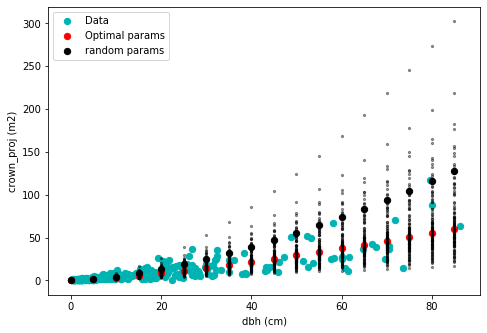

In [66]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('crown_proj (m2)')
ax.scatter(baad_acp['DBH (cm)'], baad_acp['a.cp'], s=40, color='#00b3b3', label='Data')
ax.scatter(np.arange(0,90,5), ca_opt, s=40, color='red', label='Optimal params')
ax.scatter(np.arange(0,90,5), ca_rand_p[7], s=40, color='black', label='random params')
for i in range(100):
    ax.scatter(np.arange(0,90,5), ca_rand_p[i], s=5, color='black', alpha=0.4)
#ax.set_ylim(0,150)
plt.legend()

(array([ 8.,  9., 10., 22., 21., 13., 10.,  3.,  3.,  1.]),
 array([0.11834626, 0.12619505, 0.13404384, 0.14189263, 0.14974142,
        0.15759021, 0.165439  , 0.17328779, 0.18113658, 0.18898537,
        0.19683416]),
 <a list of 10 Patch objects>)

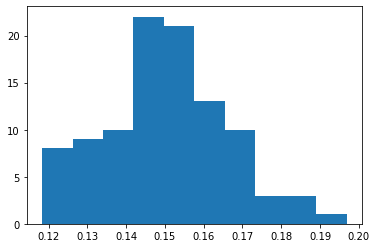

In [67]:
plt.hist(d2ca_p1_rand)

(array([ 3.,  4., 12., 18., 20., 16., 14.,  6.,  5.,  2.]),
 array([1.07148699, 1.13266599, 1.19384499, 1.25502399, 1.31620299,
        1.37738199, 1.43856099, 1.49973999, 1.56091899, 1.62209799,
        1.68327699]),
 <a list of 10 Patch objects>)

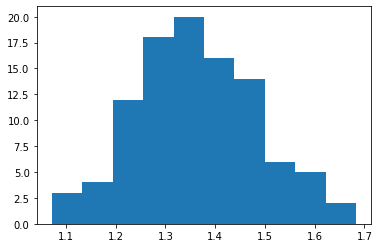

In [68]:
plt.hist(d2ca_p2_rand)

In [72]:
# d2ca_p2 > 1.77 caused problems
d2ca_params.index[d2ca_params['d2ca_p2'] >= 1.6].to_list()

[0, 31]

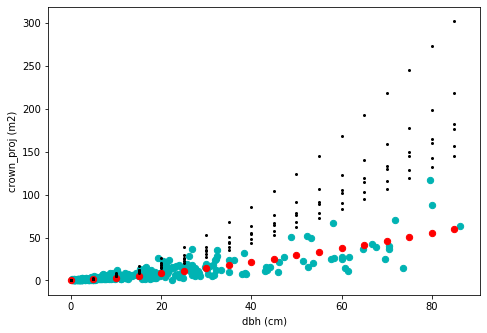

In [80]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('crown_proj (m2)')
ax.scatter(baad_acp['DBH (cm)'], baad_acp['a.cp'], s=40, color='#00b3b3', label='Data')
ax.scatter(np.arange(0,90,5), ca_opt, s=40, color='red', label='Optimal params')
ax.scatter(np.arange(0,90,5), ca_rand_p[0], s=4, color='black', label='random params')
#ax.scatter(np.arange(0,90,5), ca_rand_p[7], s=4, color='black', label='random params')
ax.scatter(np.arange(0,90,5), ca_rand_p[31], s=4, color='black', label='random params')
ax.scatter(np.arange(0,90,5), ca_rand_p[37], s=4, color='black', label='random params')
ax.scatter(np.arange(0,90,5), ca_rand_p[58], s=4, color='black', label='random params')
ax.scatter(np.arange(0,90,5), ca_rand_p[74], s=4, color='black', label='random params')
ax.scatter(np.arange(0,90,5), ca_rand_p[92], s=4, color='black', label='random params')


#ax.scatter(np.arange(0,90,5), ca_rand_p[72], s=4, color='black', label='random params')
#ax.scatter(np.arange(0,90,5), ca_rand_p[83], s=4, color='black', label='random params')
#ax.scatter(np.arange(0,90,5), ca_rand_p[85], s=4, color='black', label='random params')
#ax.scatter(np.arange(0,90,5), ca_rand_p[95], s=4, color='black', label='random params')

In [81]:
# drop the problem values from the dataframe and save to a csv

d2ca_params_clean = d2ca_params.drop([d2ca_params.index[0], d2ca_params.index[31],d2ca_params.index[37], 
                                      d2ca_params.index[58], d2ca_params.index[74], d2ca_params.index[92]])
len(d2ca_params_clean)

94

In [83]:
# read out to a csv for use in the traits matrix
#d2ca_params_clean.to_csv('/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/FATES/SCGSR_PARAMS/d2ca_params_clean_10spc_20210727.csv', index=False)


### Calculate leaf area from the random parameters

In [84]:
la_rand_p = []

for i in range(100):

    test_la = carea_2pwr(np.arange(0,90,5), d2la_p1_rand[i], d2la_p2_rand[i])
    la_rand_p.append(test_la)

la_opt = carea_2pwr(np.arange(0,90,5), d2la_p1, d2la_p2)

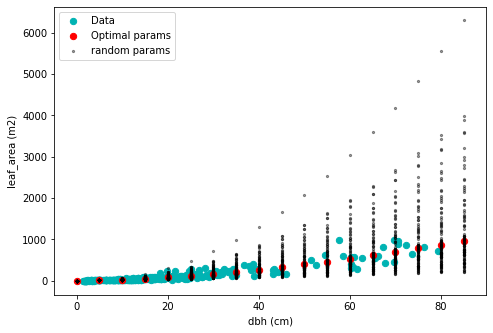

In [85]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf_area (m2)')
ax.scatter(baad_alf['DBH (cm)'], baad_alf['a.lf'], s=40, color='#00b3b3', label='Data')
ax.scatter(np.arange(0,90,5), la_opt, s=40, color='red', label='Optimal params')
ax.scatter(np.arange(0,90,5), la_rand_p[7], s=5, color='black', alpha=0.4, label='random params')
for i in range(100):
    ax.scatter(np.arange(0,90,5), la_rand_p[i], s=5, color='black', alpha=0.4)
#ax.set_ylim(0,150)
plt.legend()

(array([ 2.,  9., 12., 10., 14., 20., 14., 10.,  4.,  5.]),
 array([0.38368194, 0.40635388, 0.42902583, 0.45169777, 0.47436971,
        0.49704165, 0.51971359, 0.54238553, 0.56505748, 0.58772942,
        0.61040136]),
 <a list of 10 Patch objects>)

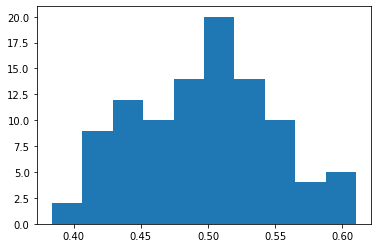

In [86]:
plt.hist(d2la_p1_rand)

(array([ 5.,  8.,  7., 24., 19., 17.,  7.,  5.,  6.,  2.]),
 array([1.3645568 , 1.43832666, 1.51209652, 1.58586638, 1.65963624,
        1.7334061 , 1.80717596, 1.88094582, 1.95471568, 2.02848554,
        2.1022554 ]),
 <a list of 10 Patch objects>)

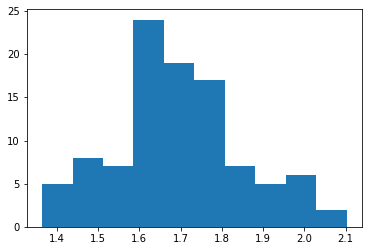

In [87]:
plt.hist(d2la_p2_rand)

In [88]:
# d2la_p2 > 1.95 caused problems
d2la_params.index[d2la_params['d2la_p2'] > 1.90].to_list()

[20, 36, 46, 61, 62, 64, 66, 79, 81, 85]

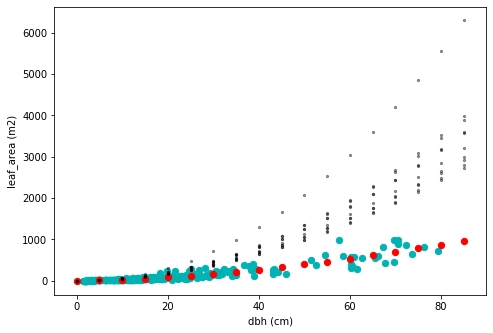

In [89]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf_area (m2)')
ax.scatter(baad_alf['DBH (cm)'], baad_alf['a.lf'], s=40, color='#00b3b3', label='Data')
ax.scatter(np.arange(0,90,5), la_opt, s=40, color='red', label='Optimal params')
ax.scatter(np.arange(0,90,5), la_rand_p[20], s=5, color='black', alpha=0.4, label='random params')
ax.scatter(np.arange(0,90,5), la_rand_p[36], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), la_rand_p[46], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), la_rand_p[61], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), la_rand_p[62], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), la_rand_p[64], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), la_rand_p[66], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), la_rand_p[79], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), la_rand_p[81], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), la_rand_p[85], s=5, color='black', alpha=0.4)

#ax.scatter(np.arange(0,90,5), la_rand_p[85], s=5, color='black', alpha=0.4)
#ax.scatter(np.arange(0,90,5), la_rand_p[94], s=5, color='black', alpha=0.4)
#ax.scatter(np.arange(0,90,5), la_rand_p[95], s=5, color='black', alpha=0.4)

In [90]:
d2la_params_clean = d2la_params.drop([d2la_params.index[20], d2la_params.index[36],d2la_params.index[46], 
                                      d2la_params.index[61], d2la_params.index[62], d2la_params.index[64],
                                           d2la_params.index[66], d2la_params.index[79], d2la_params.index[81],
                                        d2la_params.index[85]])


len(d2la_params_clean)

90

In [92]:
# read out to a csv for use in the traits matrix
#d2la_params_clean.to_csv('/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/FATES/SCGSR_PARAMS/d2la_params_clean_10spc_20210727.csv', index=False)


### Calculate leaf mass from the random parameters

In [93]:
bl_rand_p = []

for i in range(100):

    test_bl = d2blmax_2pwr(np.arange(0,90,5), d2blmax_p1_rand[i], d2blmax_p2_rand[i])
    bl_rand_p.append(test_bl)

bl_opt = d2blmax_2pwr(np.arange(0,90,5), d2blmax_p1, d2blmax_p2)

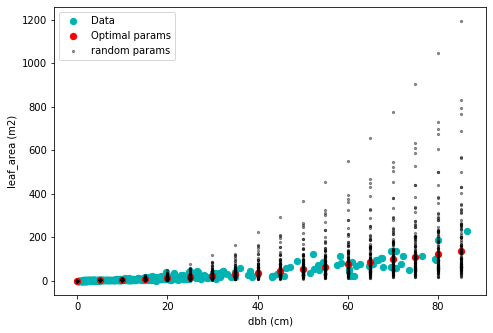

In [94]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf_area (m2)')
ax.scatter(baad_mlf['DBH (cm)'], baad_mlf['m.lf'], s=40, color='#00b3b3', label='Data')
ax.scatter(np.arange(0,90,5), bl_opt, s=40, color='red', label='Optimal params')
ax.scatter(np.arange(0,90,5), bl_rand_p[7], s=5, color='black', alpha=0.4, label='random params')
for i in range(100):
    ax.scatter(np.arange(0,90,5), bl_rand_p[i], s=5, color='black', alpha=0.4)
#ax.set_ylim(0,150)
plt.legend()

(array([ 1.,  3.,  9., 22., 24., 24.,  9.,  5.,  1.,  2.]),
 array([0.08558939, 0.09205034, 0.09851129, 0.10497223, 0.11143318,
        0.11789413, 0.12435508, 0.13081603, 0.13727697, 0.14373792,
        0.15019887]),
 <a list of 10 Patch objects>)

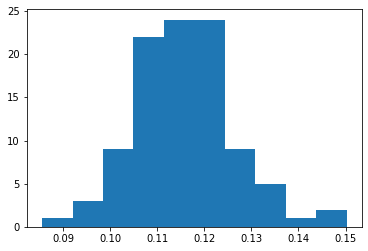

In [95]:
plt.hist(d2blmax_p1_rand)

(array([ 3.,  3., 15., 19., 18., 16., 15.,  4.,  2.,  5.]),
 array([1.3037544 , 1.395976  , 1.48819759, 1.58041919, 1.67264078,
        1.76486238, 1.85708397, 1.94930557, 2.04152716, 2.13374876,
        2.22597035]),
 <a list of 10 Patch objects>)

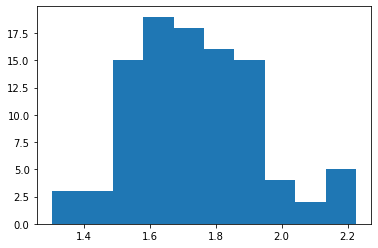

In [96]:
plt.hist(d2blmax_p2_rand)

In [104]:
# d2blmax_p2 > 2. caused problems
d2blmax_params.index[d2blmax_params['d2blmax_p2'] > 2.].to_list()

[8, 25, 27, 41, 75, 76, 78, 83, 98]

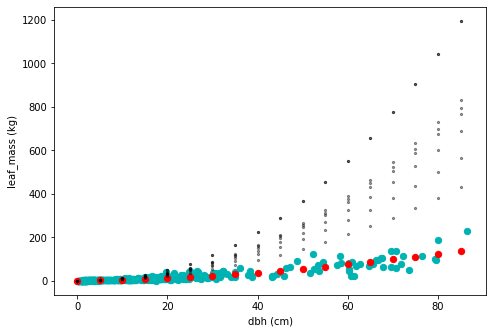

In [106]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf_mass (kg)')
ax.scatter(baad_mlf['DBH (cm)'], baad_mlf['m.lf'], s=40, color='#00b3b3', label='Data')
ax.scatter(np.arange(0,90,5), bl_opt, s=40, color='red', label='Optimal params')
ax.scatter(np.arange(0,90,5), bl_rand_p[76], s=5, color='black', alpha=0.4, label='random params')
ax.scatter(np.arange(0,90,5), bl_rand_p[83], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_p[8], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_p[41], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_p[75], s=5, color='black', alpha=0.4)
#ax.scatter(np.arange(0,90,5), bl_rand_p[76], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_p[78], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_p[98], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_p[83], s=5, color='black', alpha=0.4)

In [107]:
d2blmax_params_clean = d2blmax_params.drop([d2blmax_params.index[8], d2blmax_params.index[41],d2blmax_params.index[75], 
                                      d2blmax_params.index[76], d2blmax_params.index[78], d2blmax_params.index[83],
                                           d2blmax_params.index[98]])


len(d2blmax_params_clean)


93

In [108]:
# read out to a csv for use in the traits matrix
d2blmax_params_clean.to_csv('/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/FATES/SCGSR_PARAMS/d2blmax_params_clean_10spc_20210727.csv', index=False)
